The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

* D_* = Delinquency variables
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables

with the following features being categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

In [1]:
import os, tqdm, json, pickle, gc, zipfile, itertools, time, collections, sys, requests, schedule
import pandas as pd
import numpy as np
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from collections import defaultdict
from datetime import datetime
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
import catboost as cb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def amex_metric_official(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def get_metrics(model, X_eval, y_eval):

    pred = model.predict(X_eval)
    pred_prob = model.predict_proba(X_eval)[:, 1]

    d= {}

    d['accuracy'] = accuracy_score(y_eval, pred)
    d['f1'] = f1_score(y_eval, pred)
    d['auc'] = roc_auc_score(y_eval, pred_prob)

    y_true, y_predprob = y_eval.to_frame('target'), pd.Series(pred_prob, index = y_eval.index).to_frame('prediction')
    d['amex_metric_official'] = amex_metric_official(y_true, y_predprob)

    d['tp'] = ((y_eval==1)&(pred==1)).sum()
    d['tn'] = ((y_eval==0)&(pred==0)).sum()
    d['fp'] = ((y_eval==0)&(pred==1)).sum()
    d['fn'] = ((y_eval==1)&(pred==0)).sum()

    d['importances'] = ser_imp = pd.Series(dict(zip(X_eval.columns, model.feature_importances_))).sort_values(ascending = False)

    return d

def eval_catboost(X_train, y_train, X_eval, y_eval):

    cat_features = np.where(X_train.dtypes=='category')[0]

    params_c = {}
    params_c['cat_features'] = cat_features
    params_c['od_type'] = 'Iter'
    params_c['od_wait'] = 20    

    model = cb.CatBoostClassifier(**params_c)
    model.fit(X_train, y_train, eval_set = (X_eval, y_eval))    

    return model, get_metrics(model, X_eval, y_eval) 

def get_catboost_eval_results(X_train, y_train, X_eval, y_eval):

    i=1
    while True:

        print('> iter#{}. n_features: {}'.format(i, X_train.shape[1]))

        model, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval)

        mask = model.feature_importances_>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            
    while True:

        L_perm_imp = []
        for _ in tqdm.tqdm(range(50)):
            d_perm_imp = permutation_importance(model, X_eval, y_eval, scoring='roc_auc', n_jobs=-1, n_repeats = 1, random_state = _)    
            L_perm_imp.append(d_perm_imp['importances_mean'])
        mean_perm_imp = np.c_[L_perm_imp].mean(0)

        mask = mean_perm_imp>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]

            model, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval)

    return model, d_eval_results

def add_agg(subdf, prefix):
    ''' aggregate customer statistics with mean, sum, diff(order by time), nan rate'''
    if prefix is not None:
        d = {}
        d.update(subdf.drop(DATE_KEYS+CAT_FEATURES, 1).add_suffix(f'{prefix}__mean').mean().to_dict())
        d.update(subdf.drop(DATE_KEYS+CAT_FEATURES, 1).add_suffix(f'{prefix}__sum').sum().to_dict())
        d.update(subdf.drop(DATE_KEYS+CAT_FEATURES, 1).add_suffix(f'{prefix}__diff_mean').diff().mean().to_dict())
        return d
    else:
        d = {}
        d.update(subdf.drop(DATE_KEYS+CAT_FEATURES, 1).add_suffix('__mean').mean().to_dict())
        d.update(subdf.drop(DATE_KEYS+CAT_FEATURES, 1).add_suffix('__sum').sum().to_dict())
        d.update(subdf.drop(DATE_KEYS+CAT_FEATURES, 1).add_suffix('__diff_mean').diff().mean().to_dict())
        return d

import optuna
def objective(trial):    

    params = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),        
        'cat_features':np.where(X_train.dtypes=='category')[0],
        'random_seed': 42,        
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',        
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    params['od_type'] = 'Iter'
    params['od_wait'] = 20    
    
    model = cb.CatBoostClassifier(**params)  
    model.fit(X_train, y_train, eval_set = [(X_eval,y_eval)], early_stopping_rounds = 222, verbose = False)
    y_pred = model.predict_proba(X_eval)[:,1]
    roc_auc = roc_auc_score(y_eval, y_pred)

    return roc_auc

In [6]:
# path to datasets
PATH_TO_DATA= '.'

# target variable
TARGET_KEY = ['target']

In [7]:
# features
train = pd.read_feather(os.path.join(PATH_TO_DATA, 'train_data.ftr'))

# targets
target = train[['customer_ID']+TARGET_KEY]

train = train.drop(TARGET_KEY, 1)

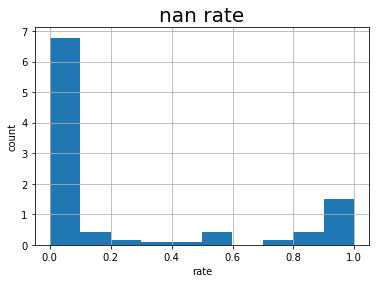

In [8]:
# null rates 
ser_nan_rate = train.isna().mean()

ser_nan_rate[ser_nan_rate!=0].hist(density=1)
plt.title('nan rate', fontsize = 20)
plt.xlabel('rate')
plt.ylabel('count');


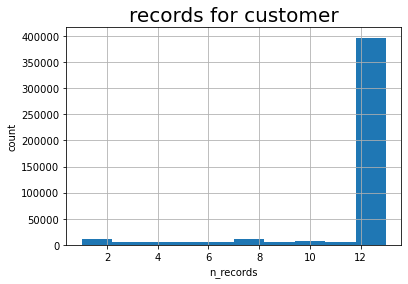

In [9]:
train['customer_ID'].value_counts().hist()
plt.title('records for customer', fontsize = 20)
plt.xlabel('n_records')
plt.ylabel('count');



In [10]:
train['year'] = train['S_2'].dt.year
train['month'] = train['S_2'].dt.month
train['day'] = train['S_2'].dt.day
train['weekday'] = train['S_2'].dt.weekday

In [11]:


# from sklearn.metrics import make_scorer
# amex_scorer = make_scorer(amex_metric_official, greater_is_better=True)

# categories
CAT_FEATURES = [
    'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116',
    'D_117', 'D_120', 'D_126'
]

# dates
DATE_KEYS = ['year', 'month', 'day','weekday']

# nulls
KEYS_WITH_NAN = train.columns[train.isna().any()]

# customers
UNIQUE_CUSTOMER_ID = train['customer_ID'].value_counts().index

In [12]:
# # dataframe for features and target
# df_data = pd.DataFrame()

# # for each customer
# for customer_ID in tqdm.tqdm(UNIQUE_CUSTOMER_ID[:1000]):

#     # data for customer
#     subdf = train.query('customer_ID==@customer_ID')

#     # customer profiling
#     d = {
#         'customer_ID':customer_ID,
#         'timestamp_min':subdf['S_2'].min().timestamp(), 
#         'timestamp_max':subdf['S_2'].max().timestamp(),        
#     }
#     d['duration'] = d['timestamp_max']-d['timestamp_min']
#     d['count'] = subdf.shape[0]
    
#     # customer data
#     subdf = subdf.sort_values('S_2').drop(['customer_ID', 'S_2'], 1)

#     # add cat features for customer    
#     d.update(subdf[CAT_FEATURES].iloc[0].to_dict())

#     # add nan rate 
#     d.update(subdf[KEYS_WITH_NAN].add_suffix('__nan_rate').isna().mean().to_dict())

#     # add customer aggregations
#     d.update(add_agg(subdf, prefix=None)) 
#     for by_key in DATE_KEYS:
#         for by_value, subsubdf in subdf.groupby(by_key):
#             d.update(add_agg(subsubdf, prefix=f'__{by_key}_{by_value}'))

#     # add target
#     target4customer = target.query('customer_ID==@customer_ID')
#     assert target4customer['target'].nunique()==1
#     d['target'] = target4customer['target'].iloc[0]

#     # add row
#     df_data = df_data.append(d, ignore_index=True)
#     del d

# df_data.to_pickle('df_data_train.pickle') 

In [13]:
df_data = pd.read_pickle('df_data_train.pickle')

In [14]:
y = df_data['target'].astype(int)
X = df_data.drop('target', 1)
X = X.set_index('customer_ID')

In [15]:
OBJ_FEATURES = X.select_dtypes('object').columns
X[OBJ_FEATURES] = X[OBJ_FEATURES].fillna('default').astype('category')

In [16]:
# split
TEST_SIZE = .1
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = TEST_SIZE)

In [17]:
# feature selection + eval results
model, d_eval_results = get_catboost_eval_results(X_train, y_train, X_eval, y_eval)

> iter#1. n_features: 28279
Learning rate set to 0.030875
0:	learn: 0.6566021	test: 0.6572920	best: 0.6572920 (0)	total: 2.5s	remaining: 41m 42s
1:	learn: 0.6260446	test: 0.6259292	best: 0.6259292 (1)	total: 5.79s	remaining: 48m 8s
2:	learn: 0.6029892	test: 0.6059162	best: 0.6059162 (2)	total: 8.06s	remaining: 44m 38s
3:	learn: 0.5801668	test: 0.5832011	best: 0.5832011 (3)	total: 9.93s	remaining: 41m 13s
4:	learn: 0.5553236	test: 0.5587641	best: 0.5587641 (4)	total: 11.6s	remaining: 38m 20s
5:	learn: 0.5342088	test: 0.5416416	best: 0.5416416 (5)	total: 13.4s	remaining: 36m 55s
6:	learn: 0.5127730	test: 0.5237768	best: 0.5237768 (6)	total: 15.2s	remaining: 35m 53s
7:	learn: 0.4971699	test: 0.5082954	best: 0.5082954 (7)	total: 16.9s	remaining: 34m 58s
8:	learn: 0.4806151	test: 0.4931654	best: 0.4931654 (8)	total: 18.7s	remaining: 34m 24s
9:	learn: 0.4628954	test: 0.4782269	best: 0.4782269 (9)	total: 20.6s	remaining: 33m 55s
10:	learn: 0.4480297	test: 0.4652312	best: 0.4652312 (10)	total:

  0%|          | 0/50 [00:00<?, ?it/s]

158:	learn: 0.0734601	test: 0.2402111	best: 0.2383731 (149)	total: 1.76s	remaining: 9.32s
159:	learn: 0.0731111	test: 0.2402146	best: 0.2383731 (149)	total: 1.77s	remaining: 9.31s
160:	learn: 0.0729958	test: 0.2401938	best: 0.2383731 (149)	total: 1.78s	remaining: 9.29s
161:	learn: 0.0720490	test: 0.2403296	best: 0.2383731 (149)	total: 1.79s	remaining: 9.28s
162:	learn: 0.0717526	test: 0.2408392	best: 0.2383731 (149)	total: 1.8s	remaining: 9.27s
163:	learn: 0.0711467	test: 0.2410050	best: 0.2383731 (149)	total: 1.82s	remaining: 9.27s
164:	learn: 0.0708256	test: 0.2407459	best: 0.2383731 (149)	total: 1.83s	remaining: 9.26s
165:	learn: 0.0703907	test: 0.2404637	best: 0.2383731 (149)	total: 1.84s	remaining: 9.24s
166:	learn: 0.0700926	test: 0.2401982	best: 0.2383731 (149)	total: 1.85s	remaining: 9.24s
167:	learn: 0.0696756	test: 0.2405920	best: 0.2383731 (149)	total: 1.86s	remaining: 9.23s
168:	learn: 0.0691302	test: 0.2406259	best: 0.2383731 (149)	total: 1.87s	remaining: 9.21s
169:	learn:

100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Learning rate set to 0.030875
0:	learn: 0.6647620	test: 0.6646137	best: 0.6646137 (0)	total: 5.36ms	remaining: 5.36s
1:	learn: 0.6295053	test: 0.6267958	best: 0.6267958 (1)	total: 10.5ms	remaining: 5.24s
2:	learn: 0.5951865	test: 0.5935478	best: 0.5935478 (2)	total: 15.2ms	remaining: 5.04s
3:	learn: 0.5695894	test: 0.5676907	best: 0.5676907 (3)	total: 20.1ms	remaining: 5.01s
4:	learn: 0.5432146	test: 0.5434707	best: 0.5434707 (4)	total: 25.1ms	remaining: 5s
5:	learn: 0.5147198	test: 0.5170629	best: 0.5170629 (5)	total: 30.3ms	remaining: 5.01s
6:	learn: 0.4952351	test: 0.4993642	best: 0.4993642 (6)	total: 34.6ms	remaining: 4.92s
7:	learn: 0.4722230	test: 0.4793414	best: 0.4793414 (7)	total: 40.2ms	remaining: 4.99s
8:	learn: 0.4510075	test: 0.4582576	best: 0.4582576 (8)	total: 44.8ms	remaining: 4.93s
9:	learn: 0.4305831	test: 0.4380370	best: 0.4380370 (9)	total: 49.7ms	remaining: 4.92s
10:	learn: 0.4145973	test: 0.4236788	best: 0.4236788 (10)	total: 55.2ms	remaining: 4.96s
11:	learn: 0.3

  0%|          | 0/50 [00:00<?, ?it/s]

111:	learn: 0.1206622	test: 0.2331162	best: 0.2327421 (98)	total: 525ms	remaining: 4.17s
112:	learn: 0.1199529	test: 0.2327730	best: 0.2327421 (98)	total: 529ms	remaining: 4.16s
113:	learn: 0.1189873	test: 0.2326422	best: 0.2326422 (113)	total: 534ms	remaining: 4.15s
114:	learn: 0.1183089	test: 0.2316963	best: 0.2316963 (114)	total: 539ms	remaining: 4.15s
115:	learn: 0.1177644	test: 0.2322039	best: 0.2316963 (114)	total: 544ms	remaining: 4.14s
116:	learn: 0.1171450	test: 0.2321581	best: 0.2316963 (114)	total: 549ms	remaining: 4.14s
117:	learn: 0.1161687	test: 0.2324646	best: 0.2316963 (114)	total: 553ms	remaining: 4.13s
118:	learn: 0.1155281	test: 0.2327381	best: 0.2316963 (114)	total: 557ms	remaining: 4.13s
119:	learn: 0.1151101	test: 0.2329293	best: 0.2316963 (114)	total: 562ms	remaining: 4.12s
120:	learn: 0.1147899	test: 0.2326133	best: 0.2316963 (114)	total: 567ms	remaining: 4.12s
121:	learn: 0.1140547	test: 0.2328612	best: 0.2316963 (114)	total: 571ms	remaining: 4.11s
122:	learn: 

100%|██████████| 50/50 [00:03<00:00, 14.92it/s]


Learning rate set to 0.030875
0:	learn: 0.6527401	test: 0.6541206	best: 0.6541206 (0)	total: 5.24ms	remaining: 5.24s
1:	learn: 0.6242642	test: 0.6268327	best: 0.6268327 (1)	total: 8.86ms	remaining: 4.42s
2:	learn: 0.5884767	test: 0.5905535	best: 0.5905535 (2)	total: 13.7ms	remaining: 4.55s
3:	learn: 0.5625233	test: 0.5666651	best: 0.5666651 (3)	total: 17.7ms	remaining: 4.41s
4:	learn: 0.5357065	test: 0.5374368	best: 0.5374368 (4)	total: 21.7ms	remaining: 4.32s
5:	learn: 0.5076900	test: 0.5078595	best: 0.5078595 (5)	total: 26.6ms	remaining: 4.4s
6:	learn: 0.4876564	test: 0.4887909	best: 0.4887909 (6)	total: 30.6ms	remaining: 4.35s
7:	learn: 0.4697580	test: 0.4714689	best: 0.4714689 (7)	total: 34.4ms	remaining: 4.26s
8:	learn: 0.4474661	test: 0.4492857	best: 0.4492857 (8)	total: 38.3ms	remaining: 4.22s
9:	learn: 0.4317202	test: 0.4364341	best: 0.4364341 (9)	total: 43.3ms	remaining: 4.28s
10:	learn: 0.4163107	test: 0.4214537	best: 0.4214537 (10)	total: 47.1ms	remaining: 4.24s
11:	learn: 0

  0%|          | 0/50 [00:00<?, ?it/s]

126:	learn: 0.1123297	test: 0.2043448	best: 0.2041968 (125)	total: 530ms	remaining: 3.64s
127:	learn: 0.1119309	test: 0.2039321	best: 0.2039321 (127)	total: 533ms	remaining: 3.63s
128:	learn: 0.1114198	test: 0.2034292	best: 0.2034292 (128)	total: 537ms	remaining: 3.62s
129:	learn: 0.1106393	test: 0.2034600	best: 0.2034292 (128)	total: 540ms	remaining: 3.61s
130:	learn: 0.1098873	test: 0.2033440	best: 0.2033440 (130)	total: 543ms	remaining: 3.6s
131:	learn: 0.1091404	test: 0.2022651	best: 0.2022651 (131)	total: 547ms	remaining: 3.6s
132:	learn: 0.1087998	test: 0.2019466	best: 0.2019466 (132)	total: 550ms	remaining: 3.59s
133:	learn: 0.1082142	test: 0.2017041	best: 0.2017041 (133)	total: 553ms	remaining: 3.58s
134:	learn: 0.1080461	test: 0.2016676	best: 0.2016676 (134)	total: 557ms	remaining: 3.57s
135:	learn: 0.1075409	test: 0.2018559	best: 0.2016676 (134)	total: 560ms	remaining: 3.56s
136:	learn: 0.1068914	test: 0.2012731	best: 0.2012731 (136)	total: 564ms	remaining: 3.55s
137:	learn: 

100%|██████████| 50/50 [00:03<00:00, 14.58it/s]


Learning rate set to 0.030875
0:	learn: 0.6601048	test: 0.6599473	best: 0.6599473 (0)	total: 4.97ms	remaining: 4.96s
1:	learn: 0.6312240	test: 0.6329956	best: 0.6329956 (1)	total: 9.98ms	remaining: 4.98s
2:	learn: 0.5954418	test: 0.5961474	best: 0.5961474 (2)	total: 14.1ms	remaining: 4.69s
3:	learn: 0.5626522	test: 0.5633563	best: 0.5633563 (3)	total: 19.7ms	remaining: 4.89s
4:	learn: 0.5370527	test: 0.5363615	best: 0.5363615 (4)	total: 24.1ms	remaining: 4.79s
5:	learn: 0.5120263	test: 0.5119683	best: 0.5119683 (5)	total: 28.1ms	remaining: 4.66s
6:	learn: 0.4861172	test: 0.4861913	best: 0.4861913 (6)	total: 32.7ms	remaining: 4.64s
7:	learn: 0.4653047	test: 0.4664894	best: 0.4664894 (7)	total: 36.8ms	remaining: 4.56s
8:	learn: 0.4471630	test: 0.4481148	best: 0.4481148 (8)	total: 40.5ms	remaining: 4.46s
9:	learn: 0.4316899	test: 0.4341604	best: 0.4341604 (9)	total: 44.1ms	remaining: 4.37s
10:	learn: 0.4114033	test: 0.4157604	best: 0.4157604 (10)	total: 48.6ms	remaining: 4.37s
11:	learn: 

  0%|          | 0/50 [00:00<?, ?it/s]

149:	learn: 0.0996620	test: 0.2065666	best: 0.2063113 (131)	total: 529ms	remaining: 3s
150:	learn: 0.0992741	test: 0.2062898	best: 0.2062898 (150)	total: 532ms	remaining: 2.99s
151:	learn: 0.0989010	test: 0.2061803	best: 0.2061803 (151)	total: 535ms	remaining: 2.98s
152:	learn: 0.0985163	test: 0.2061364	best: 0.2061364 (152)	total: 538ms	remaining: 2.98s
153:	learn: 0.0978889	test: 0.2066386	best: 0.2061364 (152)	total: 541ms	remaining: 2.97s
154:	learn: 0.0973607	test: 0.2065235	best: 0.2061364 (152)	total: 544ms	remaining: 2.96s
155:	learn: 0.0967358	test: 0.2070808	best: 0.2061364 (152)	total: 548ms	remaining: 2.96s
156:	learn: 0.0964823	test: 0.2070338	best: 0.2061364 (152)	total: 551ms	remaining: 2.96s
157:	learn: 0.0959807	test: 0.2072057	best: 0.2061364 (152)	total: 554ms	remaining: 2.95s
158:	learn: 0.0952105	test: 0.2072154	best: 0.2061364 (152)	total: 558ms	remaining: 2.95s
159:	learn: 0.0947974	test: 0.2069306	best: 0.2061364 (152)	total: 561ms	remaining: 2.94s
160:	learn: 0

100%|██████████| 50/50 [00:02<00:00, 17.28it/s]


Learning rate set to 0.030875
0:	learn: 0.6589691	test: 0.6596547	best: 0.6596547 (0)	total: 15.4ms	remaining: 15.4s
1:	learn: 0.6278042	test: 0.6286843	best: 0.6286843 (1)	total: 18.6ms	remaining: 9.29s
2:	learn: 0.5977432	test: 0.5979893	best: 0.5979893 (2)	total: 21.6ms	remaining: 7.17s
3:	learn: 0.5642879	test: 0.5618471	best: 0.5618471 (3)	total: 24.9ms	remaining: 6.19s
4:	learn: 0.5374063	test: 0.5339403	best: 0.5339403 (4)	total: 27.7ms	remaining: 5.51s
5:	learn: 0.5115310	test: 0.5087680	best: 0.5087680 (5)	total: 30.8ms	remaining: 5.1s
6:	learn: 0.4890112	test: 0.4863814	best: 0.4863814 (6)	total: 34.6ms	remaining: 4.91s
7:	learn: 0.4647539	test: 0.4624549	best: 0.4624549 (7)	total: 37.9ms	remaining: 4.69s
8:	learn: 0.4447787	test: 0.4435298	best: 0.4435298 (8)	total: 41.2ms	remaining: 4.53s
9:	learn: 0.4255114	test: 0.4255782	best: 0.4255782 (9)	total: 44.1ms	remaining: 4.37s
10:	learn: 0.4075131	test: 0.4094601	best: 0.4094601 (10)	total: 47.1ms	remaining: 4.23s
11:	learn: 0

100%|██████████| 50/50 [00:02<00:00, 20.37it/s]


Learning rate set to 0.030875
0:	learn: 0.6566429	test: 0.6577311	best: 0.6577311 (0)	total: 2.65ms	remaining: 2.65s
1:	learn: 0.6181417	test: 0.6187086	best: 0.6187086 (1)	total: 4.88ms	remaining: 2.44s
2:	learn: 0.5888301	test: 0.5878272	best: 0.5878272 (2)	total: 7.12ms	remaining: 2.37s
3:	learn: 0.5587111	test: 0.5592827	best: 0.5592827 (3)	total: 9.31ms	remaining: 2.32s
4:	learn: 0.5292086	test: 0.5306533	best: 0.5306533 (4)	total: 11.5ms	remaining: 2.29s
5:	learn: 0.5018950	test: 0.5027421	best: 0.5027421 (5)	total: 13.7ms	remaining: 2.27s
6:	learn: 0.4798189	test: 0.4790463	best: 0.4790463 (6)	total: 16.6ms	remaining: 2.35s
7:	learn: 0.4600509	test: 0.4598244	best: 0.4598244 (7)	total: 18.8ms	remaining: 2.34s
8:	learn: 0.4441253	test: 0.4434270	best: 0.4434270 (8)	total: 21.1ms	remaining: 2.32s
9:	learn: 0.4293282	test: 0.4302258	best: 0.4302258 (9)	total: 23.4ms	remaining: 2.31s
10:	learn: 0.4139678	test: 0.4129000	best: 0.4129000 (10)	total: 25.8ms	remaining: 2.32s
11:	learn: 

  8%|▊         | 4/50 [00:00<00:01, 34.57it/s]

144:	learn: 0.1014629	test: 0.1909901	best: 0.1907756 (141)	total: 333ms	remaining: 1.96s
145:	learn: 0.1006633	test: 0.1911205	best: 0.1907756 (141)	total: 335ms	remaining: 1.96s
146:	learn: 0.1002734	test: 0.1916910	best: 0.1907756 (141)	total: 337ms	remaining: 1.96s
147:	learn: 0.0996679	test: 0.1915137	best: 0.1907756 (141)	total: 340ms	remaining: 1.95s
148:	learn: 0.0991512	test: 0.1911720	best: 0.1907756 (141)	total: 342ms	remaining: 1.95s
149:	learn: 0.0987315	test: 0.1911116	best: 0.1907756 (141)	total: 344ms	remaining: 1.95s
150:	learn: 0.0981890	test: 0.1913706	best: 0.1907756 (141)	total: 346ms	remaining: 1.94s
151:	learn: 0.0975278	test: 0.1914941	best: 0.1907756 (141)	total: 348ms	remaining: 1.94s
152:	learn: 0.0970278	test: 0.1910258	best: 0.1907756 (141)	total: 350ms	remaining: 1.94s
153:	learn: 0.0966020	test: 0.1908155	best: 0.1907756 (141)	total: 353ms	remaining: 1.94s
154:	learn: 0.0960049	test: 0.1911449	best: 0.1907756 (141)	total: 355ms	remaining: 1.94s
155:	learn

100%|██████████| 50/50 [00:01<00:00, 30.57it/s]


Learning rate set to 0.030875
0:	learn: 0.6556117	test: 0.6537692	best: 0.6537692 (0)	total: 17ms	remaining: 17s
1:	learn: 0.6272580	test: 0.6253608	best: 0.6253608 (1)	total: 19ms	remaining: 9.47s
2:	learn: 0.5988907	test: 0.5980142	best: 0.5980142 (2)	total: 21ms	remaining: 7s
3:	learn: 0.5663213	test: 0.5636408	best: 0.5636408 (3)	total: 23.4ms	remaining: 5.83s
4:	learn: 0.5402398	test: 0.5379822	best: 0.5379822 (4)	total: 25.7ms	remaining: 5.11s
5:	learn: 0.5138537	test: 0.5105851	best: 0.5105851 (5)	total: 27.8ms	remaining: 4.61s
6:	learn: 0.4875159	test: 0.4830941	best: 0.4830941 (6)	total: 30.5ms	remaining: 4.33s
7:	learn: 0.4669782	test: 0.4637319	best: 0.4637319 (7)	total: 33.6ms	remaining: 4.17s
8:	learn: 0.4476288	test: 0.4450327	best: 0.4450327 (8)	total: 35.7ms	remaining: 3.93s
9:	learn: 0.4269217	test: 0.4235722	best: 0.4235722 (9)	total: 38.1ms	remaining: 3.77s
10:	learn: 0.4082574	test: 0.4061836	best: 0.4061836 (10)	total: 40.1ms	remaining: 3.6s
11:	learn: 0.3944310	te

  8%|▊         | 4/50 [00:00<00:01, 36.46it/s]

148:	learn: 0.1054525	test: 0.1979972	best: 0.1965039 (144)	total: 338ms	remaining: 1.93s
149:	learn: 0.1050254	test: 0.1973994	best: 0.1965039 (144)	total: 340ms	remaining: 1.93s
150:	learn: 0.1046013	test: 0.1975572	best: 0.1965039 (144)	total: 342ms	remaining: 1.92s
151:	learn: 0.1040557	test: 0.1976569	best: 0.1965039 (144)	total: 344ms	remaining: 1.92s
152:	learn: 0.1035777	test: 0.1979404	best: 0.1965039 (144)	total: 346ms	remaining: 1.92s
153:	learn: 0.1031856	test: 0.1982168	best: 0.1965039 (144)	total: 348ms	remaining: 1.91s
154:	learn: 0.1025508	test: 0.1976341	best: 0.1965039 (144)	total: 351ms	remaining: 1.91s
155:	learn: 0.1024123	test: 0.1977705	best: 0.1965039 (144)	total: 353ms	remaining: 1.91s
156:	learn: 0.1022846	test: 0.1979323	best: 0.1965039 (144)	total: 355ms	remaining: 1.91s
157:	learn: 0.1017183	test: 0.1981339	best: 0.1965039 (144)	total: 357ms	remaining: 1.9s
158:	learn: 0.1013247	test: 0.1984854	best: 0.1965039 (144)	total: 359ms	remaining: 1.9s
159:	learn: 

100%|██████████| 50/50 [00:01<00:00, 36.73it/s]


In [18]:
best_features = list(d_eval_results['importances'].keys())
X_train, X_eval = X_train[best_features], X_eval[best_features]

In [21]:

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

print('Best auc:', study.best_value)
print('Best params:', study.best_trial.params)

[I 2022-06-25 07:15:44,460] A new study created in memory with name: no-name-44ceda60-dc43-4ce7-bd2b-90a8733d773d
[I 2022-06-25 07:15:46,282] Trial 0 finished with value: 0.9706380575945794 and parameters: {'colsample_bylevel': 0.029248268436128863, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7824005691702405}. Best is trial 0 with value: 0.9706380575945794.
[I 2022-06-25 07:15:46,497] Trial 1 finished with value: 0.9689440993788819 and parameters: {'colsample_bylevel': 0.04902457741514879, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.8095917597440874}. Best is trial 0 with value: 0.9706380575945794.
[I 2022-06-25 07:15:50,065] Trial 2 finished with value: 0.9768492377188029 and parameters: {'colsample_bylevel': 0.08252847660738503, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6103647900292853}. Best is trial 2 with value: 0.9768492377188029.
[I 

Best auc: 0.9768492377188029
Best params: {'colsample_bylevel': 0.08252847660738503, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6103647900292853}


In [22]:
d_eval_results

{'accuracy': 0.92,
 'f1': 0.8181818181818182,
 'auc': 0.9672501411631846,
 'amex_metric_official': 0.8581514790683523,
 'tp': 18,
 'tn': 74,
 'fp': 3,
 'fn': 5,
 'importances': P_2__month_2__sum        15.663377
 D_44__year_2018__mean    11.491237
 B_2__month_11__mean      10.471707
 D_62__month_6__mean       7.802341
 D_52__weekday_2__mean     6.778087
 D_93__month_8__sum        6.770796
 S_3__month_3__mean        6.664742
 D_65__year_2018__sum      6.662352
 P_3__month_12__sum        5.565919
 D_49__weekday_5__mean     5.398683
 P_3__month_12__mean       4.931528
 D_56__year_2017__mean     4.410511
 S_3__month_1__mean        3.945813
 R_19__month_11__sum       3.442906
 dtype: float64}